## SOCIAL BUTTERFLY -- SENTIMENT ANALYSIS AND RECOMMENDATIONS

### Abstract

Sentiment analysis plays a crucial role in social media monitoring, particularly, for users’ opinion mining.
In our research project, we aim to analyze the user reviews for restaurants from the Yelp dataset. We try
to quantify the most impactful positive and negative sentiments expressed by a user for a restaurant
belonging to a specific category. As a baseline model, we first predict the user ratings using the
sentiments in the user reviews. For this, we make use of algorithms such as Multinomial Naïve Bayes,
Random Forest Classifier and Multilayer Perceptron. We then record the accuracy of predicted ratings
versus the actual ratings using the precision. We get a score of 95.37 for the Multilayer Perceptron,
93.02 for the Multinomial Naïve Bayes. Our aim is then to filter out the less impactful positive and negative words based on a threshold value of the
polarity of the occurring sentiments. To calculate the polarity, we first fit a Linear Support vector
classifier to classify the review text into positive and negative words based on a bag of words. Using the
coefficient of the support vector classifier, the frequency of the words and the total number of words,
we calculate the polarity. After this, we again predict the user ratings given the user reviews, but this
time, we consider only those reviews that contain the impactful positive words. The ratings predicted
from the meaningful sentiments are then compared with the baseline model for quantification. We find
out that the score of the Multinomail Naive Bayes model is 70.42. The second aim of this project is to recommend those
restaurants to users that have been positively reviewed with the most impactful sentiments. The results
of this project will show the difference between positive and meaningfully positive reviews. The
restaurants will be predicted based on this ‘helpful’ sentiment. The impactful negative reviews can also
be used in the future to help the restaurant owner improve their business.

### Research Idea : Quantifying the most impactful words that can determine the sentiment of a text

In traditional approaches on sentiment analysis, the sentiments are just classified according to mood and results are predicted accordingly. We are however, taking a different approach using sentiment analysis to understand the impact of certain positive words on the ratings.

### The Dataset : Yelp dataset taken from Kaggle

Kaggle link:
https://www.kaggle.com/yelp-dataset/yelp-dataset

In total, there are 5,200,000 user reviews, information on 174,000 business. We will focus on two tables which are business table and review table.

Attributes of business table are as following:

* business_id: ID of the business 
* name: name of the business
* neighborhood 
* address: address of the business
* city: city of the business
* state: state of the business
* postal_code: postal code of the business
* latitude: latitude of the business
* longitude: longitude of the business
* stars: average rating of the business
* review_count: number of reviews received
* is_open: 1 if the business is open, 0 therwise
* categories: multiple categories of the business

Attribues of review table are as following:
* review_id: ID of the review
* user_id: ID of the user
* business_id: ID of the business
* stars: ratings of the business
* date: review date
* text: review from the user
* useful: number of users who vote a review as usefull
* funny: number of users who vote a review as funny
* cool: number of users who vote a review as cool

## Direction of Analysis 


**Exploratory data  analysis**
* Count the number of each cuisine type of restaurants
* Count the number of reviews in each cuisine type of restaurants
* Visualize the distribution of restaurants according to the ratings and cuisine types of restaurants.

**Review Analysis**
* Clean the category column in business table into different cuisine types of restaurants and find out how the reviews can help this type of restaurants improve in the future
* Label the reviews as positive and negative depending upon the ratings
* Baseline model (all words = impactful + unuseful)--
* We are training the category based overall data on different classifiers and checking the precision

* Approach 1--
* Implement SVC model to get relatively positive and negative words and get score of each word
* Get the most impactful words (above a threshold) and train the data on model to predict the ratings
* Train the classifier only on the data having impactful words and checking the precision 

* We are trying the Approach 1 on different models to see which model gives the best precision.
* Expected result : the precision of Model 1 should be almost equal to Baseline model which concludes that the reviews can be best predicted only with the impactful words that we have classified and that other unuseful words do not impact the ratings 

## Data Preparation -- Importing the libraries and data cleaning 

In [1]:
import pandas as pd
import seaborn as sns
%pylab inline
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud


Populating the interactive namespace from numpy and matplotlib


paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


### Clean Yelp_business dataset 

In [2]:
business = pd.read_csv('yelp_business.csv')
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


### Filtering the Restaurants of US according to States

In [3]:
## drop unuseful column 'neighborhood' 
business.drop(['neighborhood'], axis=1, inplace=True)

## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,"5000 Arizona Mills Cr, Ste 435",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


### Classifying the data into different categories based on cuisine (Eg. American ,Italian, etc.)

In [4]:
## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]

## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
##us_restaurants.category[:20]

C:\Users\Tanushree\Anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\Tanushree\Anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


### Drop null values in category, add new category column and reset the index

In [7]:
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,category
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American
1,fNMVV_ZX7CJSDWQGdOM8Nw,Showmars Government Center,600 E 4th St,Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,Restaurants;American (Traditional),American
2,gAy4LYpsScrj8POnCW6btQ,Toast Cafe,2429 Hwy 160 W,Fort Mill,SC,29708,35.047287,-80.990559,3.5,6,0,Food;American (Traditional);Coffee & Tea;Resta...,American
3,tRVx2c89coruPRwYhGTcTw,Yuzu,13603 Madison Ave,Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,Nightlife;Izakaya;Comfort Food;Cocktail Bars;A...,Japanese
4,BnuzcebyB1AfxH0kjNWqSg,Carrabba's Italian Grill,245 Lancaster Ave,Frazer,PA,19355,40.041003,-75.542497,3.5,25,0,Restaurants;Italian;Seafood,Italian
5,Pd52CjgyEU3Rb8co6QfTPw,Flight Deck Bar & Grill,6730 S Las Vegas Blvd,Las Vegas,NV,89119,36.066914,-115.170848,4.0,13,1,Nightlife;Bars;Barbeque;Sports Bars;American (...,American
6,n7V4cD-KqqE3OXk0irJTyA,GameWorks,"6587 Las Vegas Blvd S, Ste 171",Las Vegas,NV,89119,36.068259,-115.178877,3.0,349,1,Arcades;Arts & Entertainment;Gastropubs;Restau...,American
7,B5EZlEDH6AVDk8tQGHAGqg,Villa Tap,2302 Packers Ave,Madison,WI,53704,43.123389,-89.355390,4.0,34,1,American (Traditional);Nightlife;Dive Bars;Res...,American
8,F0fEKpTk7gAmuSFI0KW1eQ,Cafe Mastrioni,"4250 S Rainbow Blvd, Ste 1007",Las Vegas,NV,89103,36.111057,-115.241688,1.5,3,0,Italian;Restaurants,Italian
9,VdlPZg2NAu8t8GkdbPLecg,Tandoori Times Indian Bistro,"8140 N Hayden Rd, Ste H115",Scottsdale,AZ,85258,33.555212,-111.900456,3.5,263,1,Restaurants;Gluten-Free;Indian;Seafood,Indian


In [8]:
## check total number of us restaurants
us_restaurants.shape

(19156, 13)

In [9]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [10]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
categories       object
category         object
dtype: object

In [11]:
## check missing values
us_restaurants.isnull().sum()

business_id      0
name             0
address          0
city             0
state            0
postal_code     22
latitude         0
longitude        0
stars            0
review_count     0
is_open          0
categories       0
category         0
dtype: int64

### Clean yelp_review dataset

In [12]:
## load review table
review = pd.read_csv('yelp_review.csv')
review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [13]:
## check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [14]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

In [15]:
us_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,category
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American
1,fNMVV_ZX7CJSDWQGdOM8Nw,Showmars Government Center,600 E 4th St,Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,Restaurants;American (Traditional),American
2,gAy4LYpsScrj8POnCW6btQ,Toast Cafe,2429 Hwy 160 W,Fort Mill,SC,29708,35.047287,-80.990559,3.5,6,0,Food;American (Traditional);Coffee & Tea;Resta...,American
3,tRVx2c89coruPRwYhGTcTw,Yuzu,13603 Madison Ave,Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,Nightlife;Izakaya;Comfort Food;Cocktail Bars;A...,Japanese
4,BnuzcebyB1AfxH0kjNWqSg,Carrabba's Italian Grill,245 Lancaster Ave,Frazer,PA,19355,40.041003,-75.542497,3.5,25,0,Restaurants;Italian;Seafood,Italian


### Merge two datasets and get new dataframe restaurants_reviews

In [16]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, how='inner', on = 'business_id')

In [17]:
restaurants_reviews.shape

(1866815, 21)

In [18]:
 ## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
    

### Add column of number of words in review and label of negative and postive reviews

In [19]:
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

### Labeling the reviews as Positive or Negative or Neutral based on user ratings

In [20]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,categories,category,review_id,user_id,review_star,date,text,useful,funny,cool,num_words_review,labels
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,I've always enjoyed my time at brick house foo...,0,0,0,37,positive
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. Came w my Unc bc Louies was clo...,0,0,0,60,negative
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,Worse service ever andI use to be a server so ...,0,0,0,106,negative
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,fCCL0pAgYGccUs8shHHIUA,PixAmdRa58XZ3hr8YLS36g,5,2015-10-09,I am updating my review to 5-stars because I t...,2,0,2,498,positive
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,-VOh0NNnIo1r24hjwSZL4Q,Hly0NEWXMxbuXa2zm_NJOQ,4,2015-01-15,I enjoyed this place. I went the night the Bu...,0,0,0,56,positive


## Visualizations

### Restaurants Distribution

### Distribution of restaurants in each category

In [21]:
plt.style.use('ggplot')

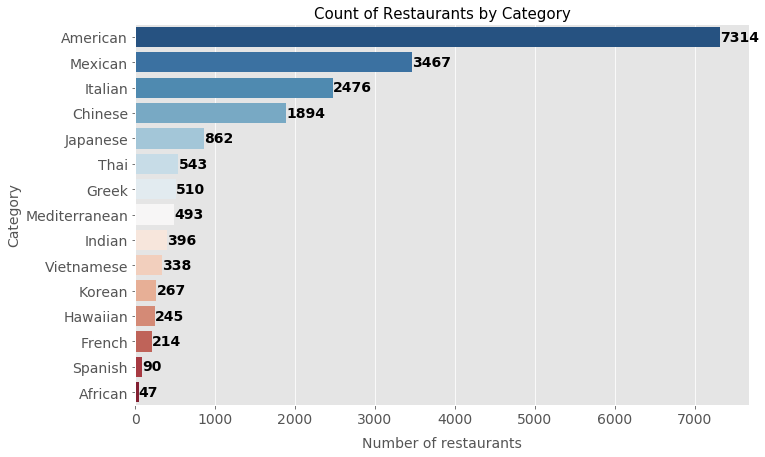

In [22]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

Categories in dark blue color have the largest number of restaurants. On the contrary, categories in dark red color have the least number of restaurants. The top 5 type of restaurants are American, Mexican, Italian, Chinese and Japanese. 

### Top 10 cities with most restaurants

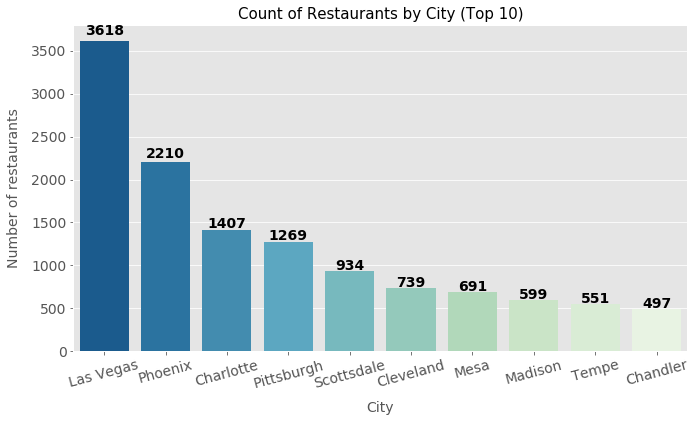

In [23]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

### Distribution of restaurants in each state

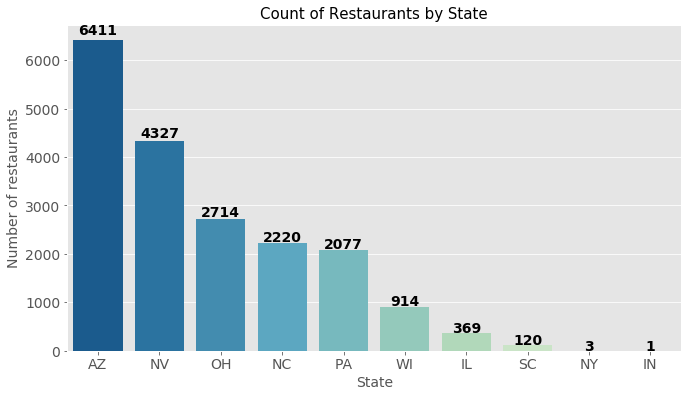

In [24]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.barplot(grouped.index, grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)

### Reviews Distribution

### Distribution of reviews by cuisine type

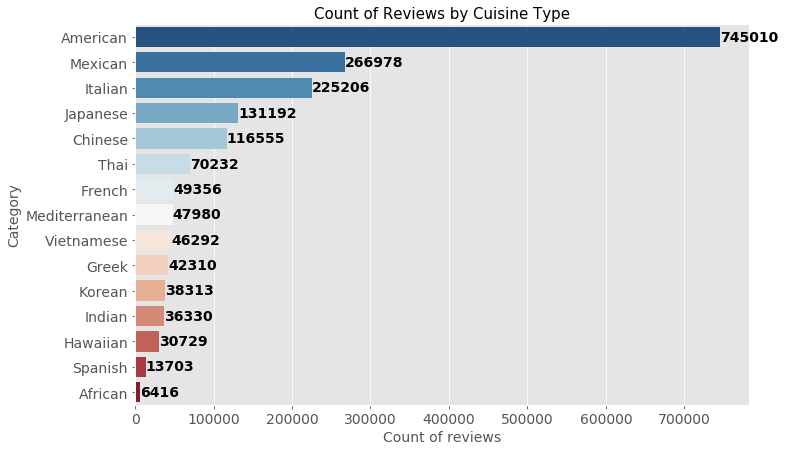

In [25]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

### Top 10 cities with most reviews

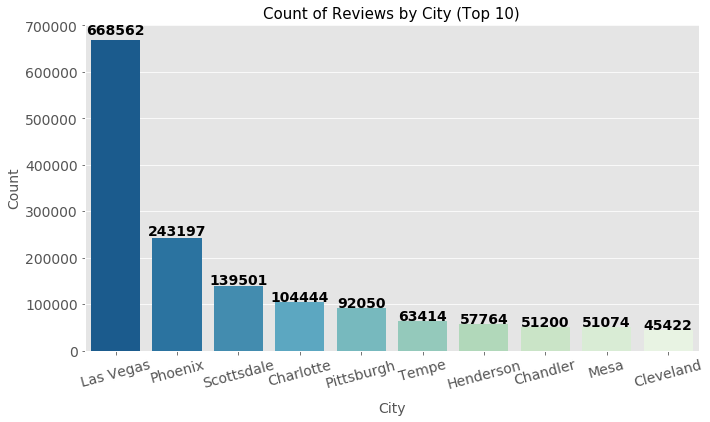

In [26]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

### Top 9 restaurants with most reviews

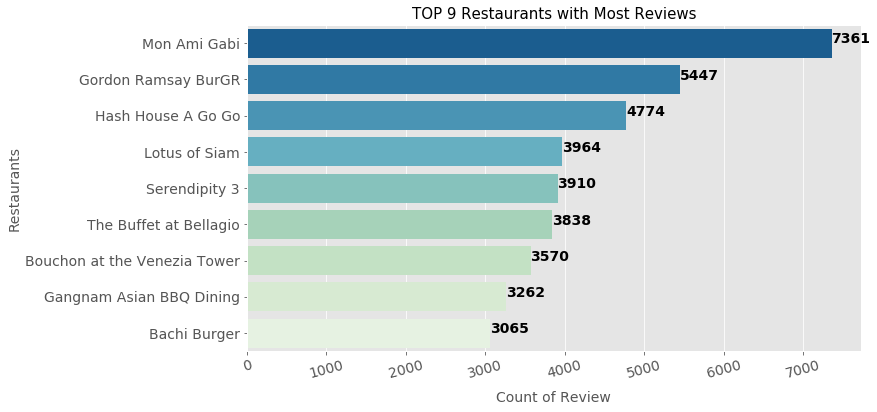

In [27]:
plt.figure(figsize=(11,6))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:9]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 9 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

### Distribution of positive and negative reviews in each category

In [28]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)

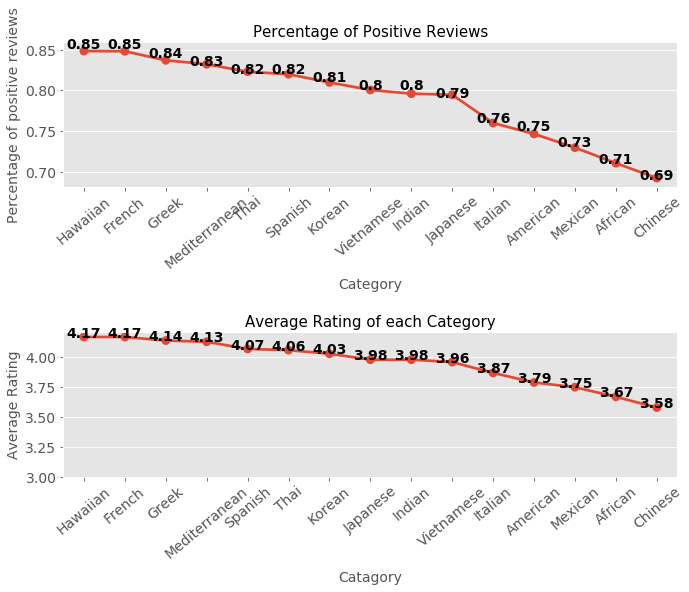

In [29]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
plt.figure(figsize=(11,8))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(grouped.index, grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)

### Average length of reviews

### Average length of words in each category

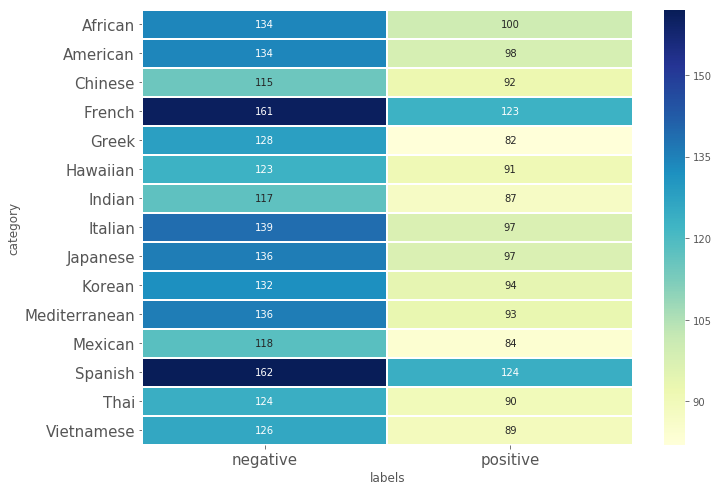

In [30]:
table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,8))
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

### Ratings Distribution

### Distribution of ratings by restaurants

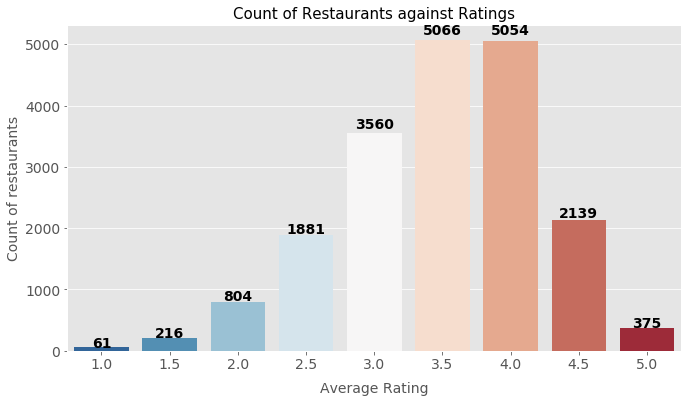

In [31]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

### Distribution of ratings by reviews

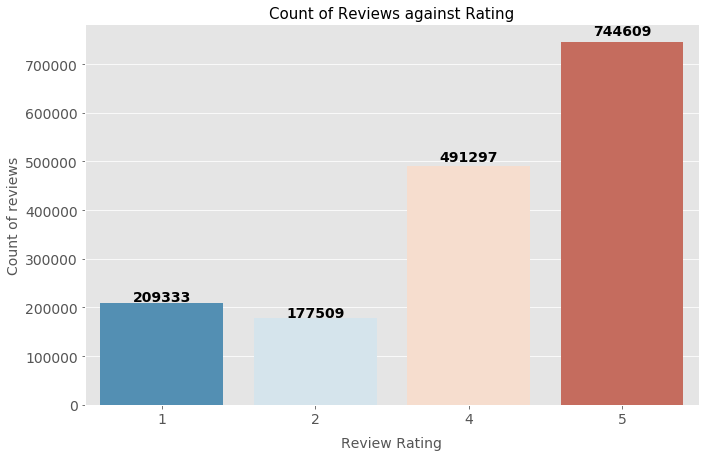

In [32]:
plt.figure(figsize=(11,7))
grouped = restaurants_reviews.review_star.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Review Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews against Rating', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

## Review Analysis

### Importing libraries

In [33]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Text cleaning and preparation

In [34]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


In [35]:
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,categories,category,review_id,user_id,review_star,date,text,useful,funny,cool,num_words_review,labels,removed_punct_text
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,i've always enjoyed my time at brick house foo...,0,0,0,37,positive,i've always enjoyed my time at brick house foo...
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. came w my unc bc louies was clo...,0,0,0,60,negative,1st time here came w my unc bc louies was clos...
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,worse service ever andi use to be a server so ...,0,0,0,106,negative,worse service ever andi use to be a server so ...
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,fCCL0pAgYGccUs8shHHIUA,PixAmdRa58XZ3hr8YLS36g,5,2015-10-09,i am updating my review to 5-stars because i t...,2,0,2,498,positive,i am updating my review to 5stars because i th...
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.1195,-81.4757,3.5000,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...,American,-VOh0NNnIo1r24hjwSZL4Q,Hly0NEWXMxbuXa2zm_NJOQ,4,2015-01-15,i enjoyed this place. i went the night the bu...,0,0,0,56,positive,i enjoyed this place i went the night the buc...


## Functions

#### Function 1 :  get_dataset (category)
We have used this function to get the data of a particular cuisine type so that we can perform our analysis specifically on that cuisine category

#### Function 2 : filter_words(review)
We have used this function to compare our bag of words against the reviews and get the words present in bag of words (both positive_words + negative_words)

In [122]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][(restaurants_reviews['categories'].str.contains(category))]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

#### Function 3 : split_data(dataset, test_size)

We have used this function to split the dataset, due to performance issues. By doing this we use half of the dataset to perform  our analysis as a result of data overloading issues

In [42]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

## Let's get into building Models

### Considering cuisine category "KOREAN"

In [232]:
Korean_reviews = get_dataset('Korean')

In [233]:
# splitting data into training and testing sets
Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)

In [234]:
print('Total %d number of reviews' % Korean_reviews.shape[0])

Total 34687 number of reviews


In [228]:
print('Total %d number of reviews' % Korean_train.shape[0])

Total 17343 number of reviews


In [238]:
Korean_reviews.text

0        i ordered the spicy pork bulgogi   and it tast...
1        note  i added the menu pages on the pictures s...
2        superb bibimbap very good korean fried chicken...
3        from a korean this place is sufficient for mit...
4        probably the best korean food in champaign sou...
5        this is a really good lunch spot food has alwa...
6        this review is based on one dish sul lung tang...
7        for the price 8 i was expecting way more food ...
8        so far everything we've tried has been great d...
9        that food was absolutely not fresh and gave me...
10       don't expect some fancy restaurant style korea...
11       i've been going here on and off for the past t...
12       i have been here about 5 times every time was ...
13       i think i've been eating too much korean food ...
14       ordered hot stone bimbimbap but it was not hot...
15       went here for the first time tonight and the f...
16       very small place and the waiter doesn't pay at.

### Initial Run : Baseline Model (All words contained in user reviews)

In [248]:
## construct features and labels
terms_train=list(Korean_reviews['text'])
class_train=list(Korean_reviews['labels'])


### Function 4 : text_process(text)

This function is used for text preparation by removing the stopwords. The output of this function is passed to the Count Vectorizer.

In [222]:
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

#### CountVectorizer :A  simple way to  tokenize a collection of text 

In [240]:
vectorizer = CountVectorizer(analyzer=text_process)
terms_train=vectorizer.fit_transform(terms_train)


In [241]:
terms_train.shape

(34687, 58630)

In [242]:
# splitting data into training and testing sets
terms_train_train,terms_train_test,class_train_train,class_train_test = train_test_split(terms_train,class_train,test_size=0.2,random_state=101)

## Baseline Model using Multinomial Naive Bayes Classifier

Multinomial Naive Bayes Classifier : It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.
Naive Bayes model is easy to build and particularly useful for very large data sets. Along with simplicity, Naive Bayes is known to outperform even highly sophisticated classification methods.

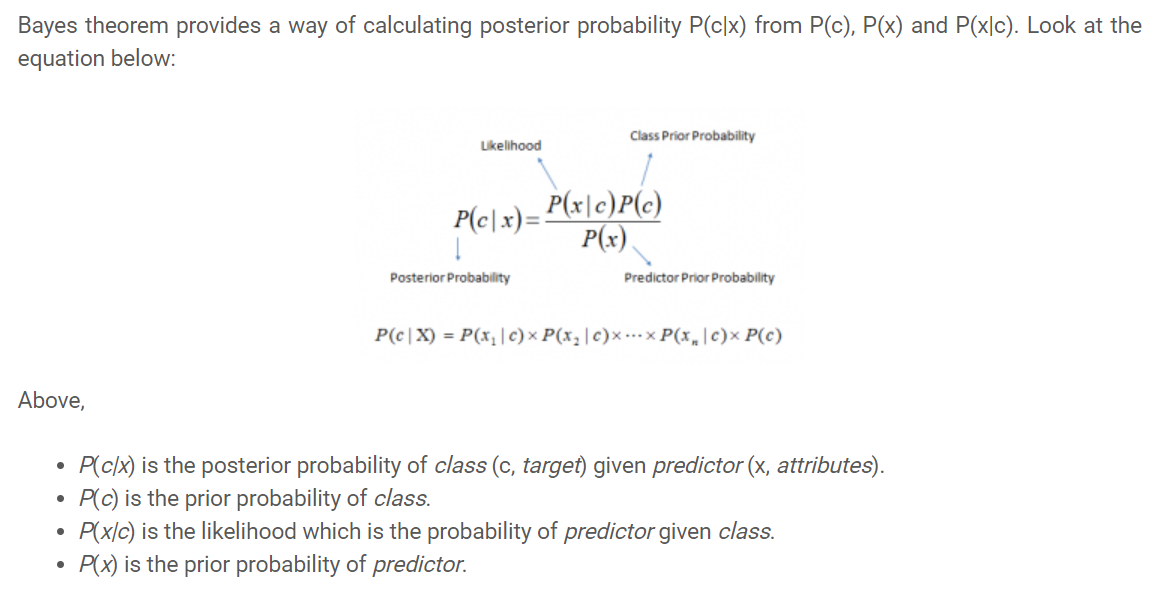

In [243]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
mnb = MultinomialNB()
mnb.fit(terms_train_train,class_train_train)
predmnb = mnb.predict(terms_train_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(class_train_test,predmnb))
print("Score:",round(accuracy_score(class_train_test,predmnb)*100,2))
print("Classification Report:",classification_report(class_train_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 982  270]
 [ 181 5505]]
Score: 93.5
Classification Report:               precision    recall  f1-score   support

    negative       0.84      0.78      0.81      1252
    positive       0.95      0.97      0.96      5686

   micro avg       0.93      0.93      0.93      6938
   macro avg       0.90      0.88      0.89      6938
weighted avg       0.93      0.93      0.93      6938



The accuracy of this model is 93.5

## Baseline model using Multilayer Perceptron Classifier

A multilayer perceptron (MLP) is a class of feedforward artificial neural network. A MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Subsequent work with multilayer perceptrons has shown that they are capable of approximating an XOR operator as well as many other non-linear functions.

In [244]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(terms_train_train,class_train_train)
predmlp = mlp.predict(terms_train_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(class_train_test,predmlp))
print("Score:",round(accuracy_score(class_train_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(class_train_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[1066  186]
 [ 107 5579]]
Score: 95.78
Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.85      0.88      1252
    positive       0.97      0.98      0.97      5686

   micro avg       0.96      0.96      0.96      6938
   macro avg       0.94      0.92      0.93      6938
weighted avg       0.96      0.96      0.96      6938



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### Approach 1
#### We will now compare our reviews against our bag of words (positive + negative).Then Support Vector Classifier will classify them as " positive"  or  "negative"

In [36]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

Support Vector Machine (SVM) model was applied to differentiate positive and
negative words in reviews, and further to get a word score to understand how positive or how negative the words are.

In [136]:
## run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)

C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [137]:
svm.coef_

array([[ 0.        ,  0.0008905 , -0.54902455, ...,  0.        ,
         0.        , -0.06906521]])

### Evaluation Metric: checking whether the prediction is right or not

In [245]:
# REVIEW
pr = Korean_reviews['text'][10]
print(pr)
print("Actual Rating: ",Korean_reviews['labels'][10])
pr_t = vectorizer.transform([pr])
print("Predicted Rating:")
mlp.predict(pr_t)[0]

don't expect some fancy restaurant style korean dishes here i kinda feel that what a usual korean household cooks then kbowl cooks it for the public foods are good tho my favorites are beef soondubu bibimbap dan any kind of stir fries like bulgogi etc not to mention their wings are awesome ask for smoothered sweetspicy sauce the downside is that they're rather expensive for such business
Actual Rating:  positive
Predicted Rating:


'positive'

### Now we will get into calculating the polarity of words

In [138]:
## create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
Korean_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

In [139]:
## get frequency of each word in all reviews in specific category (positive vs negative)
Korean_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
Korean_reviews['labels'] = class_train
Korean_frequency = Korean_reviews[Korean_reviews['labels'] =='positive'].sum()[:-1]

In [141]:
Korean_words_score.set_index('word', inplace=True)

In [142]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score['frequency'] = Korean_frequency

Polarity score: a value that reflects the polarity of
sentiment towards each restaurant category, the sentiment
score of each word was first multiplied by its frequency, and
then normalized by the total number of reviews for the specific
category of restaurants.

𝑝𝑜𝑙𝑎𝑟𝑖𝑡𝑦_𝑠𝑐𝑜𝑟𝑒 𝑡, 𝑐 = 𝑠𝑐𝑜𝑟𝑒(𝑡)×
𝑡𝑜𝑡𝑎𝑙_𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡, 𝑐)
𝑛𝑢𝑚𝑏𝑒𝑟_𝑜𝑓_ 𝑟𝑒𝑣𝑖𝑒𝑤𝑠(𝑐)

𝑝𝑜𝑙𝑎𝑟𝑖𝑡𝑦_𝑠𝑐𝑜𝑟𝑒 𝑡, 𝑐 is the index for measuring how
essential word 𝑡 is among restaurants of type 𝑐

𝑡𝑜𝑡𝑎𝑙_𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦(𝑡, 𝑐) is the total frequency of word 𝑡 in
all reviews of type 𝑐 restaurants

𝑛𝑢𝑚𝑏𝑒𝑟_𝑜𝑓_ 𝑟𝑒𝑣𝑖𝑒𝑤𝑠(𝑐) is the total number of reviews of
type 𝑐 restaurants.

In [143]:
## calculate polarity score 
Korean_polarity_score['polarity'] = Korean_polarity_score.score * Korean_polarity_score.frequency / Korean_reviews.shape[0]

Deleting rows with frequency = 0

In [144]:
Korean_polarity_score = Korean_polarity_score.drop(Korean_polarity_score[Korean_polarity_score.frequency==0].index)

### Now we will filter out the words based on a threshold value.
#### The threshold value we have considered below is 0.1, that is, all the words whose polarity value above 0.1 will be considered.

In [145]:
Korean_polarity_positive = Korean_polarity_score[Korean_polarity_score.polarity>0.1].sort_values('polarity', ascending=False)[:]

In [146]:
print(Korean_polarity_positive)

           score frequency polarity
word                               
great     0.3298      7385   0.1450
delicious 0.5868      3120   0.1090


Korean_words_score.to_csv('positivepol.csv', index = True)

In [147]:
Korean_words_score.reset_index(inplace=True)

In [148]:
Korean_filtered=list(Korean_polarity_positive.index)

In [149]:
Korean_filtered

['great', 'delicious']

### Function 5:  get_filtered(dataset,val,category)
This function is used to get a filtered dataset of  particular category above the specified threshold value of polarity. We are dropping the words with frequency = 0, taking the words above the threshold value and backtracking the corresponding reviews for a given category

In [150]:
def get_filtered(dataset,val,category):
    dataset_score = dataset.drop(dataset[dataset.frequency==0].index)
    dataset_positive = dataset[dataset.polarity>val].sort_values('polarity',ascending=False)[:]
    dataset_filtered=list(dataset_positive.index)
    for word in dataset_filtered:
        backtrack=restaurants_reviews[(restaurants_reviews['text'].str.contains(word))&(restaurants_reviews['categories'].str.contains(category))]
  
    return backtrack

In [151]:
df_filtered=get_filtered(Korean_polarity_score,0.01,'Korean')

### We will now use only those reviews that consist of the words above the threshold to predict the user ratings. 

Below, we will perform text preparation and fit the filtered text on a classification model

In [153]:
X=df_filtered['removed_punct_text']
y=df_filtered['review_star']

In [154]:
bow_transformer = CountVectorizer(analyzer=text_process)
X=bow_transformer.fit_transform(X)

In [155]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (1092, 8910)
Amount of Non-Zero occurrences:  89783
Density: 0.9227706449928672


### Making use of Multinomial Naive Bayes Classifier to predict user ratings

In [156]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [157]:
# Multinomial Naive Bayes
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
predmnb = mnb.predict(X_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[  0   0   8   2]
 [  0   0  14   1]
 [  0   0  50  79]
 [  0   0  22 152]]
Score: 61.59
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           4       0.53      0.39      0.45       129
           5       0.65      0.87      0.75       174

   micro avg       0.62      0.62      0.62       328
   macro avg       0.30      0.32      0.30       328
weighted avg       0.55      0.62      0.57       328



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Making use of XGBoost Classifier to predict the user ratings

In [158]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
predxgb = xgb.predict(X_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))

Confusion Matrix for XGBoost Classifier:
[[  0   0   4   6]
 [  1   0   9   5]
 [  0   0  47  82]
 [  0   0  21 153]]
Score:  60.98
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           4       0.58      0.36      0.45       129
           5       0.62      0.88      0.73       174

   micro avg       0.61      0.61      0.61       328
   macro avg       0.30      0.31      0.29       328
weighted avg       0.56      0.61      0.56       328



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Making use of Multilayer Perceptron Classifier for prediction of user ratings

In [159]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
predmlp = mlp.predict(X_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[  0   0   3   7]
 [  0   0  11   4]
 [  0   0  58  71]
 [  0   0  39 135]]
Score: 58.84
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        15
           4       0.52      0.45      0.48       129
           5       0.62      0.78      0.69       174

   micro avg       0.59      0.59      0.59       328
   macro avg       0.29      0.31      0.29       328
weighted avg       0.54      0.59      0.56       328



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


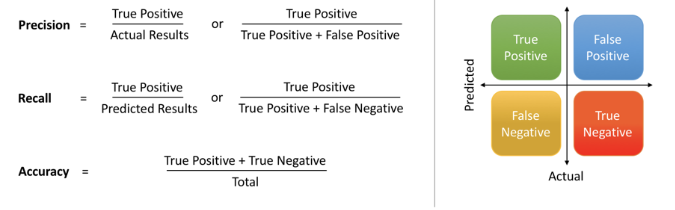

## Results: 

When the threshold value of 0.1 was considered, we attained the following accuracy measures.
* Multinomial Naive Bayes: 61.59
* XGBoost Classifier: 60.98
* Multilayer Perceptron Classifier: 58.84

### Approach 2

### Threshold value of 0.03 is considered

In [160]:
df_filtered1=get_filtered(Korean_polarity_score,0.003,'Korean')

In [105]:
X=df_filtered1['removed_punct_text']
y=df_filtered1['review_star']

In [106]:
bow_transformer = CountVectorizer()
X=bow_transformer.fit_transform(X)

In [107]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (236, 5165)
Amount of Non-Zero occurrences:  27011
Density: 2.215941719854956


In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [109]:
# Multinomial Naive Bayes
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
predmnb = mnb.predict(X_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 0  0  1]
 [ 0  2 17]
 [ 0  3 48]]
Score: 70.42
Classification Report:               precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           4       0.40      0.11      0.17        19
           5       0.73      0.94      0.82        51

   micro avg       0.70      0.70      0.70        71
   macro avg       0.38      0.35      0.33        71
weighted avg       0.63      0.70      0.63        71



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [110]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
predxgb = xgb.predict(X_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))

Confusion Matrix for XGBoost Classifier:
[[ 0  0  1]
 [ 0  3 16]
 [ 0  5 46]]
Score:  69.01
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           4       0.38      0.16      0.22        19
           5       0.73      0.90      0.81        51

   micro avg       0.69      0.69      0.69        71
   macro avg       0.37      0.35      0.34        71
weighted avg       0.62      0.69      0.64        71



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
predmlp = mlp.predict(X_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 0  0  1]
 [ 0  1 18]
 [ 0  5 46]]
Score: 66.2
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           4       0.17      0.05      0.08        19
           5       0.71      0.90      0.79        51

   micro avg       0.66      0.66      0.66        71
   macro avg       0.29      0.32      0.29        71
weighted avg       0.55      0.66      0.59        71



C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Tanushree\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


When the threshold value of 0.03 was considered, we attained the following accuracy measures.
* Multinomial Naive Bayes: 70.42
* XGBoost Classifier: 66.2
* Multilayer Perceptron Classifier: 69.41

## Recommendation using content based filtering:
Considering only those reviews that have the words that lie above the threshold value; then recommending restaurants thst hve been reviewed accordingly. 

## Function 6 : get_recommendations(top_words)
To get the recommendation of Restaurants based on the filtered reviews

In [93]:
def get_recommendations(top_words):
    for word in top_words.index:
          backtracking = df_filtered[restaurants_reviews['text'].str.contains(word)]
    recommend=backtracking[(backtracking['avg_star']>=4)&(backtracking['review_star']>=4)]
    rec=recommend.name.unique()
    return rec[:10]

In [249]:
dlf=get_recommendations(Korean_polarity_positive)

C:\Users\Tanushree\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tanushree\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [250]:
dlf

array(['Miga Korean Bistro', 'Doh Korean BBQ', "Cafe' Ga Hyang",
       'Gen Korean BBQ House', 'KoMex Fusion', 'Simplee Sushi',
       'Oishii Bento', 'Good Fella Korean Bistro', 'Yuzu Kitchen',
       'Bonchon Chicken'], dtype=object)

## Function 7 : get_polarity_score(dataset)

This is a generalized function which includes all the preliminary steps involved in calculating the polarity of words of a particular cuisine.

In [257]:
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_=list(dataset['text'])
    class_=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    terms_=vectorizer.fit_transform(terms_)
    #feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(terms_, class_)
    #svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(terms_.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    
    
    return cuisine_polarity_score

## Conclusion: 

* We have executed 3 models above to predict the user ratings based on the user reviews. 
* We observe that Multinomial Naive Bayes gives the best score of 70.42. 
* This may not be better than the baseline model, but that can be explained by the fact that we have considered lesser data than that of the baseline model. 
* Since we are taking only the positive reviews and polarity above, the precision for the 5 star ratings is pretty good, that is, 0.71

Thus we can conclude that just a subset of all the review text is the most determinant for the user ratings, although not as good as the whole set. 

This been said, we shouldn't completely ignore the words that have less impact on the review.

On the whole it is better to keep the threshold value as low as possible so that it can consider more impactful words.


Thus we have justified the importance of impactfulness of words in Sentiment Analysis.

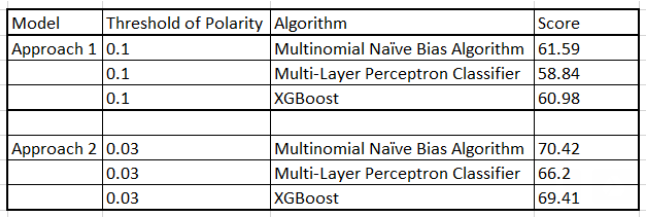

## Citations
* https://en.wikipedia.org/wiki/Multilayer_perceptron
* https://www.analyticsvidhya.com/blog/2016/08/evolution-core-concepts-deep-learning-neural-networks/
* https://www.kaggle.com/omkarsabnis/sentiment-analysis-on-the-yelp-reviews-dataset
* https://www.kaggle.com/yelp-dataset/yelp-dataset/kernels
* https://github.com/zoehuang7/Yelp-Review-Analysis/blob/master/Group%2021%20-%20Yelp%20Reviw%20Analysis.ipynb
* https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/


## License


Copyright 2019 TANUSHREE DESHMUKH, Prithviraj Patil, Varada Dharmadhikari

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.